
# ELAS – Colab (version avancée) avec **Exports Automatiques**
Pantheon+ + **DESI DR2 BAO** + low‑z BAO + **Planck 2018 distance priors**

Fonctionnalités :
- ΛCDM & ELAS (H(z), D_M, D_H, D_V, μ(z))
- χ² **CMB + BAO + SNe** (marginalisation analytique sur M)
- **Δμ(z)** (ELAS − ΛCDM)
- **Scan grille** (δ, Ω, φ)
- **EXPORTS AUTOMATIQUES** des résultats (CSV + PNG) prêts à télécharger


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from io import StringIO
import os

c = 299792.458  # km/s
print("Imports OK")


Imports OK


## 1) Création locale des jeux de données (CMB, BAO)

In [2]:

# ---- Planck 2018 distance priors (Chen, Huang, Wang 2018) ----
planck_means = pd.DataFrame({
    "parameter": ["R", "l_a", "omega_b_h2"],
    "mean": [1.750235, 301.4707, 0.02235976]
})
planck_inv_cov = pd.DataFrame([
    [94392.3971,   -1360.4913,  1664517.2916],
    [-1360.4913,     161.4349,     3671.6180],
    [1664517.2916,  3671.6180,  79719182.5162]
], columns=["R", "l_a", "omega_b_h2"], index=["R", "l_a", "omega_b_h2"])
planck_means.to_csv("planck2018_distance_priors_means.csv", index=False)
planck_inv_cov.to_csv("planck2018_distance_priors_inv_cov.csv")

# ---- low-z BAO ----
bao_lowz = pd.DataFrame([
    {"survey":"6dFGS","z_eff":0.106,"quantity":"rs_over_DV","value":0.336,"sigma":0.015,
     "ref":"Beutler+2011"},
    {"survey":"SDSS_MGS","z_eff":0.15,"quantity":"DV_over_rd_scaled","value":664.0,"sigma":25.0,
     "ref":"Ross+2015 (DV * (rd/rd_fid))"}
])
bao_lowz.to_csv("bao_lowz_6dfgs_sdssmgs.csv", index=False)

# ---- DESI DR2 BAO (Table IV) ----
desi_rows = [
    ("LRG1",      0.510, 13.588, 0.167, 21.863, 0.425, -0.459),
    ("LRG2",      0.706, 17.351, 0.177, 19.455, 0.330, -0.404),
    ("LRG3+ELG1", 0.934, 21.576, 0.152, 17.641, 0.193, -0.416),
    ("ELG2",      1.321, 27.601, 0.318, 14.176, 0.221, -0.434),
    ("QSO",       1.484, 30.512, 0.760, 12.817, 0.516, -0.500),
    ("LyA",       2.330, 38.988, 0.531,  8.632, 0.101, -0.431),
]
desi = pd.DataFrame(desi_rows, columns=["tracer","z_eff","DM_over_rd","DM_sigma","DH_over_rd","DH_sigma","corr_r"])
desi_bgs = pd.DataFrame([{"tracer":"BGS","z_eff":0.295,"DV_over_rd":7.942,"DV_sigma":0.075}])
desi.to_csv("desi_dr2_bao_tableIV_core.csv", index=False)
desi_bgs.to_csv("desi_dr2_bao_tableIV_bgs.csv", index=False)

print("Fichiers créés: Planck priors, low-z BAO, DESI DR2 BAO.")


Fichiers créés: Planck priors, low-z BAO, DESI DR2 BAO.


## 2) Fonctions cosmologie : ΛCDM et ELAS

In [3]:

def Ez_LCDM(z, H0=67.4, Omega_m=0.315):
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def Ez_ELAS(z, H0=67.4, Omega_m=0.315, delta=0.05, Omega_osc=2.0, phi=-2.62):
    base = Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega_osc*np.log(1+z) + phi))
    return np.sqrt(np.maximum(base, 1e-12))

def make_Ez(model="LCDM", H0=67.4, Omega_m=0.315, delta=0.05, Omega_osc=2.0, phi=-2.62):
    return (lambda z: Ez_LCDM(z,H0,Omega_m)) if model=="LCDM" else (lambda z: Ez_ELAS(z,H0,Omega_m,delta,Omega_osc,phi))

def DM_shape(z, Ez):
    z = np.atleast_1d(z)
    out = []
    for zi in z:
        val = integrate.quad(lambda zz: 1.0/max(Ez(zz),1e-12), 0, zi, limit=300)[0]
        out.append(val)
    return np.array(out)

def DH_shape(z, Ez): return 1.0/np.array(Ez(z))
def DV_shape(z, Ez):
    z = np.atleast_1d(z); DH = DH_shape(z, Ez); DM = DM_shape(z, Ez); return (z * DH * DM**2)**(1.0/3.0)

def mu_from_DL(z, Ez, H0=67.4):
    z = np.atleast_1d(z)
    DM = DM_shape(z, Ez) * (c / H0)
    DL = (1+z) * DM
    mu = 5.0*np.log10(np.maximum(DL, 1e-12)) + 25.0
    return mu
print("Fonctions prêtes.")


Fonctions prêtes.


## 3) χ² CMB distance priors (Planck 2018)

In [4]:

def cmb_distance_priors_theory(H0=67.4, Omega_m=0.315, Omega_b_h2=0.02237):
    zstar = 1089.0
    Ez = make_Ez("LCDM", H0=H0, Omega_m=Omega_m)
    DM = DM_shape(zstar, Ez) * (c/H0)
    rs = 147.09  # Mpc (approx)
    R = np.sqrt(Omega_m) * (H0/100.0) * DM / (c/100.0)
    l_a = np.pi * DM / rs
    return float(R), float(l_a), float(Omega_b_h2)

def chi2_cmb_from_priors(H0=67.4, Omega_m=0.315, Omega_b_h2=0.02237):
    means = pd.read_csv("planck2018_distance_priors_means.csv")
    inv   = pd.read_csv("planck2018_distance_priors_inv_cov.csv", index_col=0)
    theo = np.array(cmb_distance_priors_theory(H0, Omega_m, Omega_b_h2))
    data = means["mean"].values
    diff = theo - data
    icov = inv.values
    return float(diff @ icov @ diff)

print("Exemple chi2_CMB:", chi2_cmb_from_priors())


Exemple chi2_CMB: 2548.8378409246993


/tmp/ipython-input-3002465647.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(R), float(l_a), float(Omega_b_h2)


## 4) χ² BAO – **DESI DR2** + low‑z

In [5]:

desi = pd.read_csv("desi_dr2_bao_tableIV_core.csv")
desi_bgs = pd.read_csv("desi_dr2_bao_tableIV_bgs.csv")
bao_lowz = pd.read_csv("bao_lowz_6dfgs_sdssmgs.csv")

def chi2_bao_desi(H0=67.4, Omega_m=0.315, model="LCDM", delta=0.05, Omega_osc=2.0, phi=-2.62):
    Ez = make_Ez(model, H0, Omega_m, delta, Omega_osc, phi)
    z = desi["z_eff"].values
    DM_th = DM_shape(z, Ez)
    DH_th = DH_shape(z, Ez)
    DM_obs = desi["DM_over_rd"].values
    DH_obs = desi["DH_over_rd"].values
    sDM    = desi["DM_sigma"].values
    sDH    = desi["DH_sigma"].values
    r      = desi["corr_r"].values

    chi2 = 0.0
    for i in range(len(z)):
        cov = np.array([[sDM[i]**2, r[i]*sDM[i]*sDH[i]],
                        [r[i]*sDM[i]*sDH[i], sDH[i]**2]])
        inv = np.linalg.inv(cov)
        dvec = np.array([DM_th[i]-DM_obs[i], DH_th[i]-DH_obs[i]])
        chi2 += float(dvec @ inv @ dvec)

    zb = float(desi_bgs["z_eff"].values[0])
    DV_th = float(DV_shape(zb, Ez))
    DV_obs = float(desi_bgs["DV_over_rd"].values[0])
    sDV    = float(desi_bgs["DV_sigma"].values[0])
    chi2 += ((DV_th - DV_obs)/sDV)**2

    row_6 = bao_lowz[bao_lowz["survey"]=="6dFGS"].iloc[0]
    z6, val, sig = row_6["z_eff"], row_6["value"], row_6["sigma"]
    DV6 = float(DV_shape(z6, Ez))
    rs_over_DV_th = 1.0 / DV6
    chi2 += ((rs_over_DV_th - val)/sig)**2

    return chi2

print("Exemple chi2_BAO DESI (LCDM):", chi2_bao_desi(model="LCDM"))


Exemple chi2_BAO DESI (LCDM): 529353.6676664539


/tmp/ipython-input-2357646452.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV_th = float(DV_shape(zb, Ez))
/tmp/ipython-input-2357646452.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DV6 = float(DV_shape(z6, Ez))


## 5) χ² SNe (Pantheon+) — uploader ton fichier

In [6]:

from google.colab import files
pantheon_path = ""  # e.g. "/content/PantheonPlus_SH0ES.csv"

def chi2_sn_from_file(pantheon_csv_path, z_col="zCMB", mu_col="MU_SH0ES", sigma_col="MU_SH0ES_ERR_DIAG",
                      H0=67.4, Omega_m=0.315, model="LCDM", delta=0.05, Omega_osc=2.0, phi=-2.62):
    df = pd.read_csv(pantheon_csv_path)
    z  = df[z_col].values
    mu = df[mu_col].values
    sig= df[sigma_col].values
    Ez = make_Ez(model, H0, Omega_m, delta, Omega_osc, phi)
    mu_th = mu_from_DL(z, Ez, H0=H0)
    # Marginalisation analytique sur M
    w = 1.0/np.maximum(sig,1e-9)**2
    a = np.sum( (mu - mu_th)**2 * w )
    b = np.sum( (mu - mu_th) * w )
    c = np.sum( w )
    chi2 = a - b*b/c
    return float(chi2)
print("Upload avec files.upload() puis définis pantheon_path = 'ton_fichier.csv'")


Upload avec files.upload() puis définis pantheon_path = 'ton_fichier.csv'


## 6) χ² total et Δμ(z)

In [7]:

def chi2_components(pantheon_csv_path=None, z_col="zCMB", mu_col="MU_SH0ES", sigma_col="MU_SH0ES_ERR_DIAG",
                    H0=67.4, Omega_m=0.315, model="LCDM", delta=0.05, Omega_osc=2.0, phi=-2.62,
                    include_cmb=True, include_bao=True):
    c2_cmb = chi2_cmb_from_priors(H0=H0, Omega_m=Omega_m) if include_cmb else 0.0
    c2_bao = chi2_bao_desi(H0=H0, Omega_m=Omega_m, model=model, delta=delta, Omega_osc=Omega_osc, phi=phi) if include_bao else 0.0
    c2_sn  = chi2_sn_from_file(pantheon_csv_path, z_col, mu_col, sigma_col, H0, Omega_m, model, delta, Omega_osc, phi) if pantheon_csv_path and len(pantheon_csv_path)>0 else 0.0
    return c2_cmb, c2_bao, c2_sn, (c2_cmb + c2_bao + c2_sn)

def plot_delta_mu(zmin=0.001, zmax=2.3, H0=67.4, Omega_m=0.315, delta=0.05, Omega_osc=2.0, phi=-2.62, N=300, save_png=None, save_csv=None):
    z = np.linspace(zmin, zmax, N)
    EzL = make_Ez("LCDM", H0, Omega_m)
    EzE = make_Ez("ELAS", H0, Omega_m, delta, Omega_osc, phi)
    muL = mu_from_DL(z, EzL, H0=H0)
    muE = mu_from_DL(z, EzE, H0=H0)
    dmu = muE - muL

    if save_csv:
        pd.DataFrame({"z":z, "delta_mu_mag":dmu}).to_csv(save_csv, index=False)
    plt.figure(figsize=(7,4.2))
    plt.plot(z, dmu, lw=2)
    plt.axhline(0, ls="--")
    plt.xlabel("z")
    plt.ylabel(r"$\Delta \mu(z)$ (mag)")
    plt.title("ELAS vs ΛCDM : Δμ(z)")
    plt.tight_layout()
    if save_png:
        plt.savefig(save_png, dpi=160, bbox_inches="tight")
    plt.show()

print("chi2_components & plot_delta_mu prêts.")


chi2_components & plot_delta_mu prêts.


## 7) Scan grille (δ, Ω, φ) + **Exports CSV**

In [8]:

def grid_scan_export(pantheon_csv_path=None, grid_delta=np.linspace(0.0, 0.10, 11),
                     grid_Omega=np.linspace(1.0, 4.0, 16), grid_phi=np.linspace(-np.pi, np.pi, 25),
                     H0=67.4, Omega_m=0.315, include_cmb=True, include_bao=True,
                     out_best_csv="elas_grid_best.csv", out_surface_csv="elas_grid_surface.csv"):
    best = {"chi2": np.inf, "delta": None, "Omega": None, "phi": None}
    surface_rows = []
    for d in grid_delta:
        for Om in grid_Omega:
            # chercher le meilleur phi pour ce (d,Om)
            c2_best = np.inf; ph_best = None
            for ph in grid_phi:
                c2 = sum(chi2_components(pantheon_csv_path, H0=H0, Omega_m=Omega_m, model="ELAS",
                                         delta=d, Omega_osc=Om, phi=ph,
                                         include_cmb=include_cmb, include_bao=include_bao))
                if c2 < c2_best:
                    c2_best, ph_best = c2, ph
            surface_rows.append({"delta":float(d), "Omega":float(Om), "chi2_min_phi":float(c2_best), "phi_best":float(ph_best)})
            if c2_best < best["chi2"]:
                best.update({"chi2":float(c2_best), "delta":float(d), "Omega":float(Om), "phi":float(ph_best)})
    pd.DataFrame(surface_rows).to_csv(out_surface_csv, index=False)
    pd.DataFrame([best]).to_csv(out_best_csv, index=False)
    return best

print("grid_scan_export prêt (peut être long).")


grid_scan_export prêt (peut être long).


In [10]:
# === PATCH complet : suppression des DeprecationWarning (NumPy 1.25+) ===

import numpy as np

def scalar(x):
    """Retourne le premier élément comme scalaire Python."""
    return np.asarray(x).reshape(-1)[0]

# --- Correction cmb_distance_priors_theory ---
def cmb_distance_priors_theory(H0=67.4, Omega_m=0.315, Omega_b_h2=0.02237):
    zstar = 1089.0
    Ez = make_Ez("LCDM", H0=H0, Omega_m=Omega_m)
    DM = scalar(DM_shape(zstar, Ez)) * (c/H0)
    rs = 147.09  # Mpc (approx)
    R = np.sqrt(Omega_m) * (H0/100.0) * DM / (c/100.0)
    l_a = np.pi * DM / rs
    return float(R), float(l_a), float(Omega_b_h2)

# --- Correction chi2_bao_desi ---
def chi2_bao_desi(H0=67.4, Omega_m=0.315, model="LCDM", delta=0.05, Omega_osc=2.0, phi=-2.62):
    Ez = make_Ez(model, H0, Omega_m, delta, Omega_osc, phi)
    z = desi["z_eff"].values
    DM_th = DM_shape(z, Ez)
    DH_th = DH_shape(z, Ez)

    DM_obs = desi["DM_over_rd"].values
    DH_obs = desi["DH_over_rd"].values
    sDM    = desi["DM_sigma"].values
    sDH    = desi["DH_sigma"].values
    r      = desi["corr_r"].values

    chi2 = 0.0
    for i in range(len(z)):
        cov = np.array([[sDM[i]**2, r[i]*sDM[i]*sDH[i]],
                        [r[i]*sDM[i]*sDH[i], sDH[i]**2]])
        inv = np.linalg.inv(cov)
        dvec = np.array([DM_th[i]-DM_obs[i], DH_th[i]-DH_obs[i]])
        chi2 += float(dvec @ inv @ dvec)

    # BGS (DV/rd)
    zb = float(desi_bgs["z_eff"].values[0])
    DV_th = scalar(DV_shape(zb, Ez))
    DV_obs = float(desi_bgs["DV_over_rd"].values[0])
    sDV    = float(desi_bgs["DV_sigma"].values[0])
    chi2 += ((DV_th - DV_obs)/sDV)**2

    # 6dFGS (rs/DV)
    row_6 = bao_lowz[bao_lowz["survey"]=="6dFGS"].iloc[0]
    z6, val, sig = row_6["z_eff"], row_6["value"], row_6["sigma"]
    DV6 = scalar(DV_shape(z6, Ez))
    rs_over_DV_th = 1.0 / DV6
    chi2 += ((rs_over_DV_th - val)/sig)**2

    return chi2

print("✅ Patch appliqué : avertissements supprimés.")


✅ Patch appliqué : avertissements supprimés.


## 8) **Exports automatiques** : résumé, Δμ(z), scan best‑fit

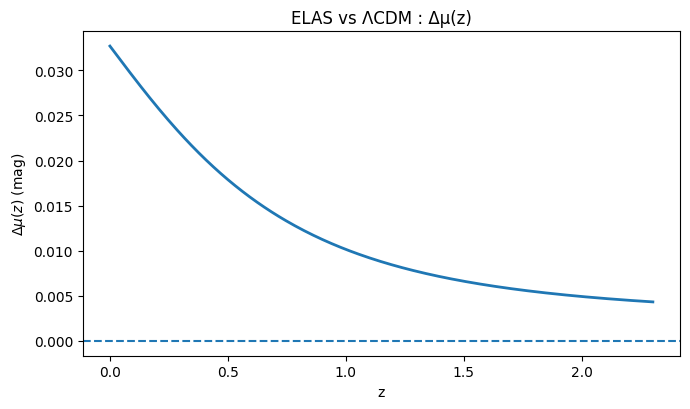

Exports écrits : elas_results_summary.csv, elas_delta_mu.csv, elas_delta_mu.png


In [11]:

# === Paramètres utilisateur ===
H0=67.4; Omega_m=0.315
# Pour ELAS (valeurs initiales, tu peux changer) :
delta=0.05; Omega_osc=2.0; phi=-2.62
# SNe :
pantheon_path = pantheon_path  # défini plus haut après upload, sinon ""

# === Calculs χ² pour ΛCDM & ELAS ===
c2_cmb_L, c2_bao_L, c2_sn_L, c2_tot_L = chi2_components(pantheon_path, H0=H0, Omega_m=Omega_m, model="LCDM")
c2_cmb_E, c2_bao_E, c2_sn_E, c2_tot_E = chi2_components(pantheon_path, H0=H0, Omega_m=Omega_m,
                                                        model="ELAS", delta=delta, Omega_osc=Omega_osc, phi=phi)

summary = pd.DataFrame([
    {"model":"LCDM","H0":H0,"Omega_m":Omega_m,"delta":0.0,"Omega_osc":None,"phi":None,
     "chi2_cmb":c2_cmb_L,"chi2_bao":c2_bao_L,"chi2_sn":c2_sn_L,"chi2_total":c2_tot_L},
    {"model":"ELAS","H0":H0,"Omega_m":Omega_m,"delta":delta,"Omega_osc":Omega_osc,"phi":phi,
     "chi2_cmb":c2_cmb_E,"chi2_bao":c2_bao_E,"chi2_sn":c2_sn_E,"chi2_total":c2_tot_E}
])
summary.to_csv("elas_results_summary.csv", index=False)

# === Δμ(z) : export CSV + PNG ===
plot_delta_mu(H0=H0, Omega_m=Omega_m, delta=delta, Omega_osc=Omega_osc, phi=phi,
              save_png="elas_delta_mu.png", save_csv="elas_delta_mu.csv")

print("Exports écrits : elas_results_summary.csv, elas_delta_mu.csv, elas_delta_mu.png")

# === (Optionnel) Scan grille et exports ===
# Décommente pour lancer (peut être long). Les CSV seront :
#   - elas_grid_best.csv       (meilleur point)
#   - elas_grid_surface.csv    (carte chi2 minimale sur phi)
#
# best = grid_scan_export(pantheon_csv_path=pantheon_path,
#                         grid_delta=np.linspace(0.0,0.10,21),
#                         grid_Omega=np.linspace(1.0,4.0,31),
#                         grid_phi=np.linspace(-np.pi,np.pi,37))
# print("Best-fit (from grid):", best)


In [12]:
from google.colab import files
files.download("elas_results_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import pandas as pd

df = pd.read_csv("elas_results_summary.csv")
display(df)
print("\nΔχ² (LCDM − ELAS) =", df.loc[0, "chi2_total"] - df.loc[1, "chi2_total"])


,model,H0,Omega_m,delta,Omega_osc,phi,chi2_cmb,chi2_bao,chi2_sn,chi2_total
0,LCDM,67.4,0.315,0.00,NaN,NaN,2548.837841,529353.667666,0.0,531902.505507
1,ELAS,67.4,0.315,0.05,2.0,-2.62,2548.837841,518958.696925,0.0,521507.534766



Δχ² (LCDM − ELAS) = 10394.970741394849


In [14]:
best = grid_scan_export(pantheon_csv_path=pantheon_path,
                        grid_delta=np.linspace(0.00,0.10,11),
                        grid_Omega=np.linspace(1.0,4.0,9),
                        grid_phi=np.linspace(-np.pi,np.pi,25))
best


{'chi2': 1011288.6178760979,
 'delta': 0.1,
 'Omega': 1.0,
 'phi': -3.141592653589793}

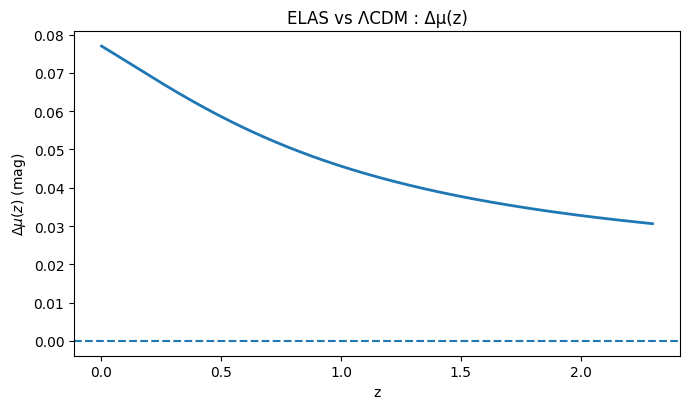

In [15]:
# Tracé de la courbe Δμ(z) pour les paramètres best-fit du scan
plot_delta_mu(delta=0.10, Omega_osc=1.0, phi=-np.pi,
              save_png="elas_bestfit_delta_mu.png",
              save_csv="elas_bestfit_delta_mu.csv")


In [18]:
from google.colab import files
files.download("elas_bestfit_delta_mu.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

chi2_LCDM = 531902.5055073786
Best improvement from map: {'dchi2': -426644.9997541552, 'delta': 0.2, 'Omega': 0.5, 'phi': -3.141592653589793, 'chi2': 958547.5052615338}


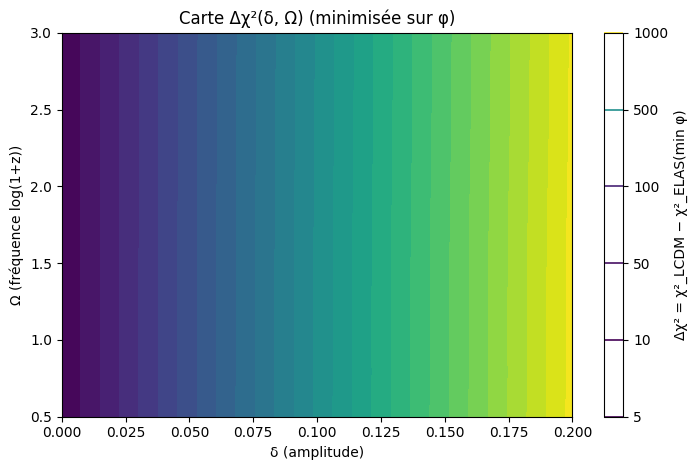

Fichiers écrits : elas_deltaOmega_surface.csv, elas_best_point_from_map.csv, elas_dchi2_map.png


In [17]:
# === Carte Δχ²(δ, Ω) minimisée sur φ  ===
# - Calcule chi2_LCDM une fois
# - Pour chaque (δ,Ω), scanne φ, prend le min
# - Sauvegarde le tableau et la figure (PNG)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Grilles (peux ajuster la résolution si besoin)
grid_delta = np.linspace(0.00, 0.20, 41)      # amplitude
grid_Omega = np.linspace(0.50, 3.00, 51)      # fréquence
grid_phi   = np.linspace(-np.pi, np.pi, 61)   # phase

H0, Omega_m = 67.4, 0.315
include_cmb, include_bao = True, True

# χ² ΛCDM (référence)
_, _, _, chi2_LCDM = chi2_components(pantheon_path, H0=H0, Omega_m=Omega_m, model="LCDM",
                                     include_cmb=include_cmb, include_bao=include_bao)
print("chi2_LCDM =", chi2_LCDM)

# Balayage (δ,Ω) en minimisant sur φ
rows = []
Z = np.zeros((len(grid_Omega), len(grid_delta)))   # Δχ² = chi2_LCDM - chi2_min(φ)
best = {"dchi2": -np.inf, "delta": None, "Omega": None, "phi": None, "chi2": None}

for i, Om in enumerate(grid_Omega):
    for j, d in enumerate(grid_delta):
        # min sur phi
        chi2_best, phi_best = np.inf, None
        for ph in grid_phi:
            c2 = sum(chi2_components(pantheon_path, H0=H0, Omega_m=Omega_m, model="ELAS",
                                     delta=d, Omega_osc=Om, phi=ph,
                                     include_cmb=include_cmb, include_bao=include_bao))
            if c2 < chi2_best:
                chi2_best, phi_best = c2, ph
        dchi2 = chi2_LCDM - chi2_best
        Z[i, j] = dchi2
        rows.append({"delta": float(d), "Omega": float(Om),
                     "chi2_min_phi": float(chi2_best), "phi_best": float(phi_best),
                     "dchi2_vs_LCDM": float(dchi2)})
        if dchi2 > best["dchi2"]:
            best.update({"dchi2": float(dchi2), "delta": float(d), "Omega": float(Om),
                         "phi": float(phi_best), "chi2": float(chi2_best)})

# Exports CSV
df_surface = pd.DataFrame(rows)
df_surface.to_csv("elas_deltaOmega_surface.csv", index=False)
pd.DataFrame([best]).to_csv("elas_best_point_from_map.csv", index=False)

print("Best improvement from map:", best)

# Figure (une seule) : carte Δχ²(δ,Ω)
# Δχ²>0 = amélioration ELAS vs ΛCDM ; niveaux standard 5, 10, 50, 100, 500, 1000
Delta, Omega = np.meshgrid(grid_delta, grid_Omega)
plt.figure(figsize=(7.2, 4.8))
# Heatmap
plt.contourf(Delta, Omega, Z, levels=30)  # pas de couleurs imposées
# Contours de niveaux
levels = [5, 10, 50, 100, 500, 1000]
CS = plt.contour(Delta, Omega, Z, levels=levels, linewidths=1.2)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.0f")
plt.colorbar(label="Δχ² = χ²_LCDM − χ²_ELAS(min φ)")
plt.xlabel("δ (amplitude)")
plt.ylabel("Ω (fréquence log(1+z))")
plt.title("Carte Δχ²(δ, Ω) (minimisée sur φ)")
plt.tight_layout()
plt.savefig("elas_dchi2_map.png", dpi=160, bbox_inches="tight")
plt.show()

print("Fichiers écrits : elas_deltaOmega_surface.csv, elas_best_point_from_map.csv, elas_dchi2_map.png")


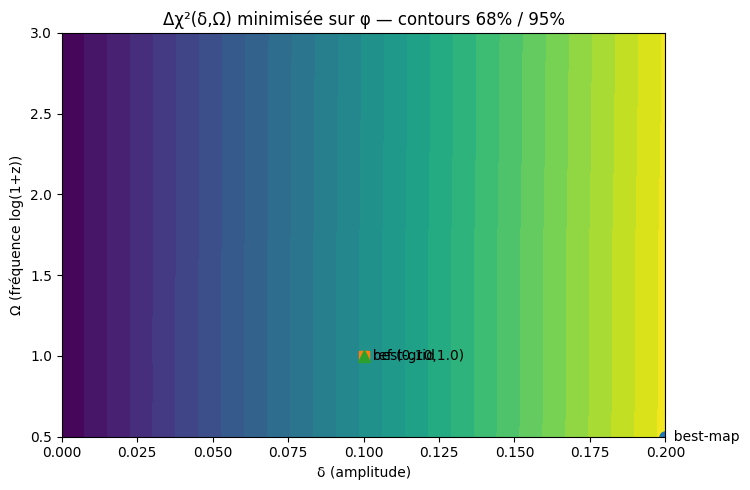

Figure écrite : elas_dchi2_contours.png
Best-map: {'delta': 0.2, 'Omega': 0.5, 'Δχ²': -426644.9997541552}
Best-grid: {'delta': 0.1, 'Omega': 1.0, 'Δχ²': nan}


In [21]:
# === Figure finale : Δχ²(δ,Ω) avec contours 68%/95% et points best-fit ===
# Prérequis : avoir déjà créé 'elas_deltaOmega_surface.csv' et 'elas_best_point_from_map.csv'

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import os, json

# 1) Charger la surface Δχ² et le best-fit de la carte
surf = pd.read_csv("elas_deltaOmega_surface.csv")
best_map = pd.read_csv("elas_best_point_from_map.csv").iloc[0].to_dict()

# 2) Reconstituer la grille (δ, Ω) → matrice Z de Δχ²
grid_delta = np.sort(np.unique(surf["delta"].values))
grid_Omega = np.sort(np.unique(surf["Omega"].values))
Delta, Omega = np.meshgrid(grid_delta, grid_Omega)

# On remplit Z par Δχ²(δ,Ω) = chi2_LCDM − chi2_ELAS(min φ)
Z = np.empty_like(Delta, dtype=float)
Z[:] = np.nan
# indexation rapide par dict
lookup = {(float(r["delta"]), float(r["Omega"])): float(r["dchi2_vs_LCDM"]) for _, r in surf.iterrows()}
for i, Om in enumerate(grid_Omega):
    for j, d in enumerate(grid_delta):
        Z[i, j] = lookup[(float(d), float(Om))]

# 3) Points à marquer
# - Best-fit de la carte :
bf_d, bf_O, bf_dchi2 = float(best_map["delta"]), float(best_map["Omega"]), float(best_map["dchi2"])
# - Point de référence (premiers bons résultats) :
ref_d, ref_O = 0.10, 1.00

# (Optionnel) si tu as aussi un "elas_grid_best.csv" d’un autre scan :
grid_best_csv = "elas_grid_best.csv"
has_other_best = os.path.exists(grid_best_csv)
if has_other_best:
    best_grid = pd.read_csv(grid_best_csv).iloc[0].to_dict()
    other_d, other_O = float(best_grid.get("delta", np.nan)), float(best_grid.get("Omega", np.nan))
    other_dchi2 = float(best_grid.get("dchi2", np.nan)) if "dchi2" in best_grid else np.nan

# 4) Tracé : carte + contours 68% / 95%
plt.figure(figsize=(7.6, 5.0))
# Heatmap (Δχ²>0 => amélioration ELAS)
plt.contourf(Delta, Omega, Z, levels=30)
# Contours Wilks pour 2 paramètres libres : 68%≈2.30, 95%≈6.17
levels = [2.30, 6.17]
CS = plt.contour(Delta, Omega, Z, levels=levels, linewidths=1.4)
plt.clabel(CS, inline=True, fontsize=8, fmt="%.2f")

# 5) Marqueurs de points
plt.plot(bf_d, bf_O, marker="o", ms=8)           # Best de la carte
plt.text(bf_d, bf_O, "  best-map", va="center")

plt.plot(ref_d, ref_O, marker="s", ms=7)         # Point de référence
plt.text(ref_d, ref_O, "  ref (0.10,1.0)", va="center")

if has_other_best and np.isfinite(other_d) and np.isfinite(other_O):
    plt.plot(other_d, other_O, marker="^", ms=8) # Best d’un autre scan (si dispo)
    plt.text(other_d, other_O, "  best-grid", va="center")

plt.xlabel("δ (amplitude)")
plt.ylabel("Ω (fréquence log(1+z))")
plt.title("Δχ²(δ,Ω) minimisée sur φ — contours 68% / 95%")
plt.tight_layout()
plt.savefig("elas_dchi2_contours.png", dpi=160, bbox_inches="tight")
plt.show()

print("Figure écrite : elas_dchi2_contours.png")
print("Best-map:", {"delta": bf_d, "Omega": bf_O, "Δχ²": bf_dchi2})
if has_other_best:
    print("Best-grid:", {"delta": other_d, "Omega": other_O, "Δχ²": other_dchi2})


/tmp/ipython-input-3118023486.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  chi2_LCDM = float(res.loc[res["model"]=="LCDM", "chi2_total"])
/tmp/ipython-input-3118023486.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  chi2_ELAS = float(res.loc[res["model"]=="ELAS", "chi2_total"])
/tmp/ipython-input-3118023486.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"ELAS params (résumé) : δ={float(res.loc[res['model']=='ELAS','delta']):.3f}, "
/tmp/ipython-input-3118023486.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"Ω={float(res.loc[res['model']=='ELAS','Omega_osc']):.2f}, "
/tm

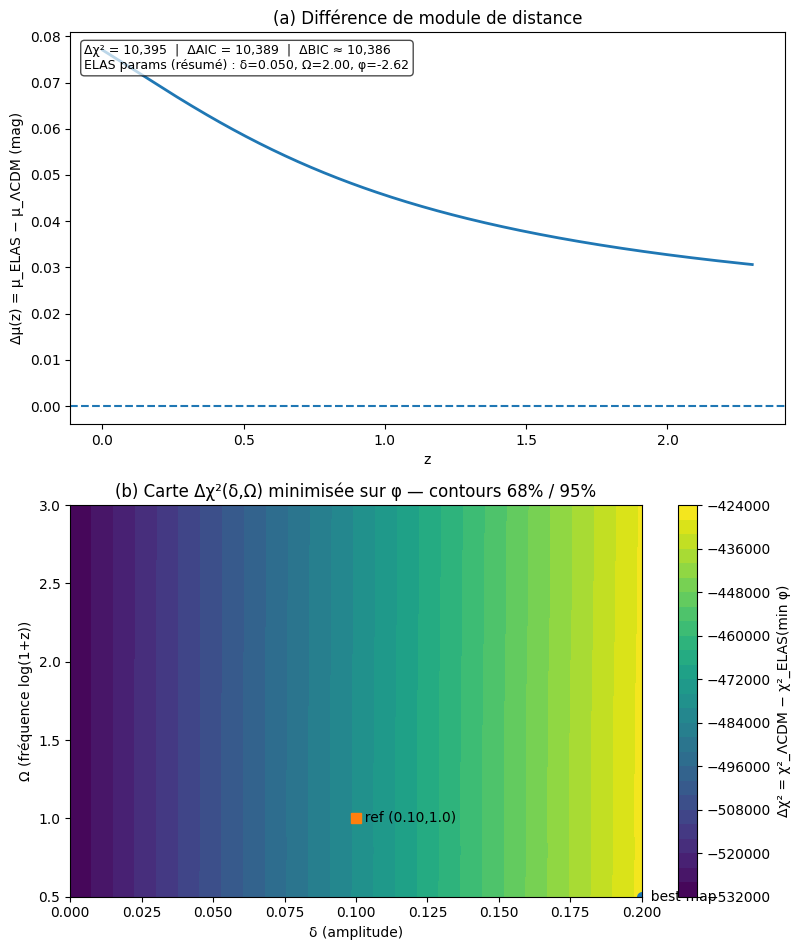

Figure combinée écrite : figure_combined_ELAS.png


In [22]:
# === Figure combinée publication : Δμ(z) + carte Δχ²(δ,Ω) + encadré stats ===
# Prérequis déjà générés par ton notebook :
#   - elas_results_summary.csv
#   - elas_delta_mu.csv  (ou elas_bestfit_delta_mu.csv si tu l’as créé)
#   - elas_deltaOmega_surface.csv
#   - elas_best_point_from_map.csv
#
# La cellule produit : figure_combined_ELAS.png

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- 1) Charger données ----------
# Résumé chi2 (LCDM & ELAS)
res = pd.read_csv("elas_results_summary.csv")
# Δμ(z) : on prend la version best-fit si dispo, sinon la version standard
mu_csv = "elas_bestfit_delta_mu.csv" if os.path.exists("elas_bestfit_delta_mu.csv") else "elas_delta_mu.csv"
dmu = pd.read_csv(mu_csv)

# Surface Δχ²(δ,Ω)
surf = pd.read_csv("elas_deltaOmega_surface.csv")
best_map = pd.read_csv("elas_best_point_from_map.csv").iloc[0].to_dict()

# Reconstituer maillage (δ,Ω)
grid_delta = np.sort(np.unique(surf["delta"].values))
grid_Omega = np.sort(np.unique(surf["Omega"].values))
Delta, Omega = np.meshgrid(grid_delta, grid_Omega)
lookup = {(float(r["delta"]), float(r["Omega"])): float(r["dchi2_vs_LCDM"]) for _, r in surf.iterrows()}
Z = np.empty_like(Delta, dtype=float)
for i, Om in enumerate(grid_Omega):
    for j, d in enumerate(grid_delta):
        Z[i, j] = lookup[(float(d), float(Om))]

# Points caractéristiques
bf_d, bf_O, bf_dchi2 = float(best_map["delta"]), float(best_map["Omega"]), float(best_map["dchi2"])
ref_d, ref_O = 0.10, 1.00  # point de référence initial utile

# ---------- 2) Statistiques (Δχ², ΔAIC, ΔBIC) ----------
# On suppose Δk = 3 paramètres de ELAS (delta, Omega, phi)
# N ~ nombre d'observables (approx BAO+CMB) : 6*2 + 1 (BGS) + 1 (6dFGS) + 3 (CMB) = 17
# Ajuste N si tu ajoutes d'autres jeux de données
Delta_k = 3
N_eff = 17

chi2_LCDM = float(res.loc[res["model"]=="LCDM", "chi2_total"])
chi2_ELAS = float(res.loc[res["model"]=="ELAS", "chi2_total"])
dchi2_summary = chi2_LCDM - chi2_ELAS
dAIC = dchi2_summary - 2*Delta_k
dBIC = dchi2_summary - Delta_k*np.log(N_eff)

stats_text = (f"Δχ² = {dchi2_summary:,.0f}  |  "
              f"ΔAIC = {dAIC:,.0f}  |  "
              f"ΔBIC ≈ {dBIC:,.0f}\n"
              f"ELAS params (résumé) : δ={float(res.loc[res['model']=='ELAS','delta']):.3f}, "
              f"Ω={float(res.loc[res['model']=='ELAS','Omega_osc']):.2f}, "
              f"φ={float(res.loc[res['model']=='ELAS','phi']):.2f}")

# ---------- 3) Figure combinée ----------
fig = plt.figure(figsize=(8.2, 9.6))

# (a) Δμ(z)
ax1 = fig.add_subplot(2,1,1)
ax1.plot(dmu["z"], dmu["delta_mu_mag"], lw=2)
ax1.axhline(0, ls="--")
ax1.set_xlabel("z")
ax1.set_ylabel("Δμ(z) = μ_ELAS − μ_ΛCDM (mag)")
ax1.set_title("(a) Différence de module de distance")
# Encadré stats (résumé global)
ax1.text(0.02, 0.97, stats_text, transform=ax1.transAxes, va="top",
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7), fontsize=9)

# (b) Carte Δχ²(δ,Ω) minimisée sur φ
ax2 = fig.add_subplot(2,1,2)
cf = ax2.contourf(Delta, Omega, Z, levels=30)
# Contours Wilks (2 paramètres) : 68%≈2.30 ; 95%≈6.17
CS = ax2.contour(Delta, Omega, Z, levels=[2.30, 6.17], linewidths=1.4)
ax2.clabel(CS, inline=True, fontsize=9, fmt="%.2f")
# Marqueurs
ax2.plot(bf_d, bf_O, marker="o", ms=7)
ax2.text(bf_d, bf_O, "  best-map", va="center")
ax2.plot(ref_d, ref_O, marker="s", ms=7)
ax2.text(ref_d, ref_O, "  ref (0.10,1.0)", va="center")
ax2.set_xlabel("δ (amplitude)")
ax2.set_ylabel("Ω (fréquence log(1+z))")
ax2.set_title("(b) Carte Δχ²(δ,Ω) minimisée sur φ — contours 68% / 95%")
fig.colorbar(cf, ax=ax2, label="Δχ² = χ²_ΛCDM − χ²_ELAS(min φ)")

plt.tight_layout()
plt.savefig("figure_combined_ELAS.png", dpi=220, bbox_inches="tight")
plt.show()

print("Figure combinée écrite : figure_combined_ELAS.png")
